In [1]:
import pandas as pd 
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt 
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models 
from torchvision.datasets import ImageFolder
!pip install torchsummary
import torchsummary
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import cv2
import os 
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from pathlib import Path
from glob import glob

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
train_df = pd.DataFrame({"path":[] , "label":[] , "class_id":[]})
train_path ="/kaggle/input/smoking/Training/Training"
label_list = ['notsmoking','smoking']
img_list = glob(train_path+'/*.jpg')

In [3]:
for img in img_list:
    file_name = os.path.splitext(img)[0].split("/")[-1]
    if file_name[:len(label_list[0])] == label_list[0]:
        new_data = pd.DataFrame({"path":img , "label":label_list[0] , "class_id":0} , index=[1])
        train_df = pd.concat([train_df , new_data] , ignore_index = True)
    elif file_name[0:len(label_list[1])] == label_list[1]:
        new_data = pd.DataFrame({"path":img , "label":label_list[1] , "class_id":1} , index=[1])
        train_df = pd.concat([train_df , new_data] , ignore_index = True)

In [4]:
train_df.head()

,path,label,class_id
0,/kaggle/input/smoking/Training/Training/smokin...,smoking,1.0
1,/kaggle/input/smoking/Training/Training/smokin...,smoking,1.0
2,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0.0
3,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0.0
4,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0.0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   path      716 non-null    object 
 1   label     716 non-null    object 
 2   class_id  716 non-null    float64
dtypes: float64(1), object(2)
memory usage: 16.9+ KB


In [6]:
train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)

In [7]:
val_df = pd.DataFrame({"path":[] , "label":[] , "class_id":[]})
val_path ="/kaggle/input/smoking/Validation/Validation"
label_list = ['notsmoking','smoking']
img_list = glob(val_path+'/*.jpg')

In [8]:
for img in img_list:
    file_name = os.path.splitext(img)[0].split("/")[-1]
    if file_name[:len(label_list[0])] == label_list[0]:
        new_data = pd.DataFrame({"path":img , "label":label_list[0] , "class_id":0} , index = [1])
        val_df = pd.concat([val_df , new_data]  , ignore_index=True)
    elif file_name[:len(label_list[1])] == label_list[1]:
        new_data = pd.DataFrame({"path":img , "label":label_list[1] , "class_id":1} , index = [1])
        val_df = pd.concat([val_df , new_data] , ignore_index=True)

In [9]:
val_df[['path']] = val_df[['path']].astype(str)
val_df[['label']] = val_df[['label']].astype(str)
val_df[['class_id']] = val_df[['class_id']].astype(int)

<Axes: xlabel='label', ylabel='count'>

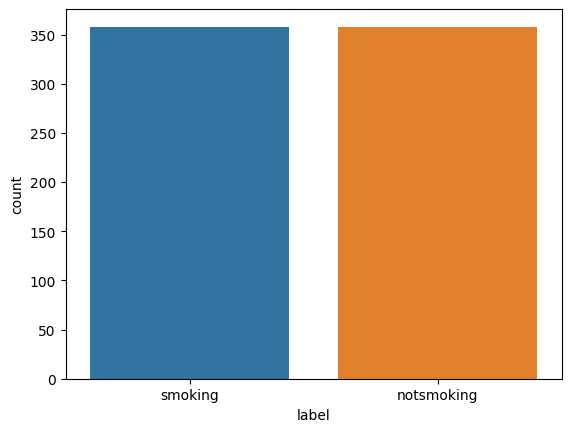

In [10]:
sns.countplot(train_df, x='label')

<Axes: xlabel='label', ylabel='count'>

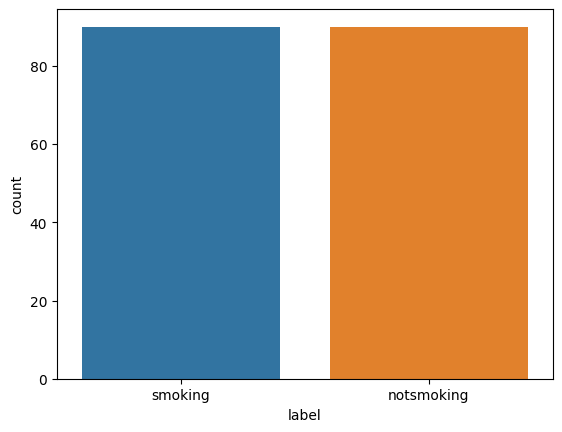

In [11]:
sns.countplot(val_df, x='label')

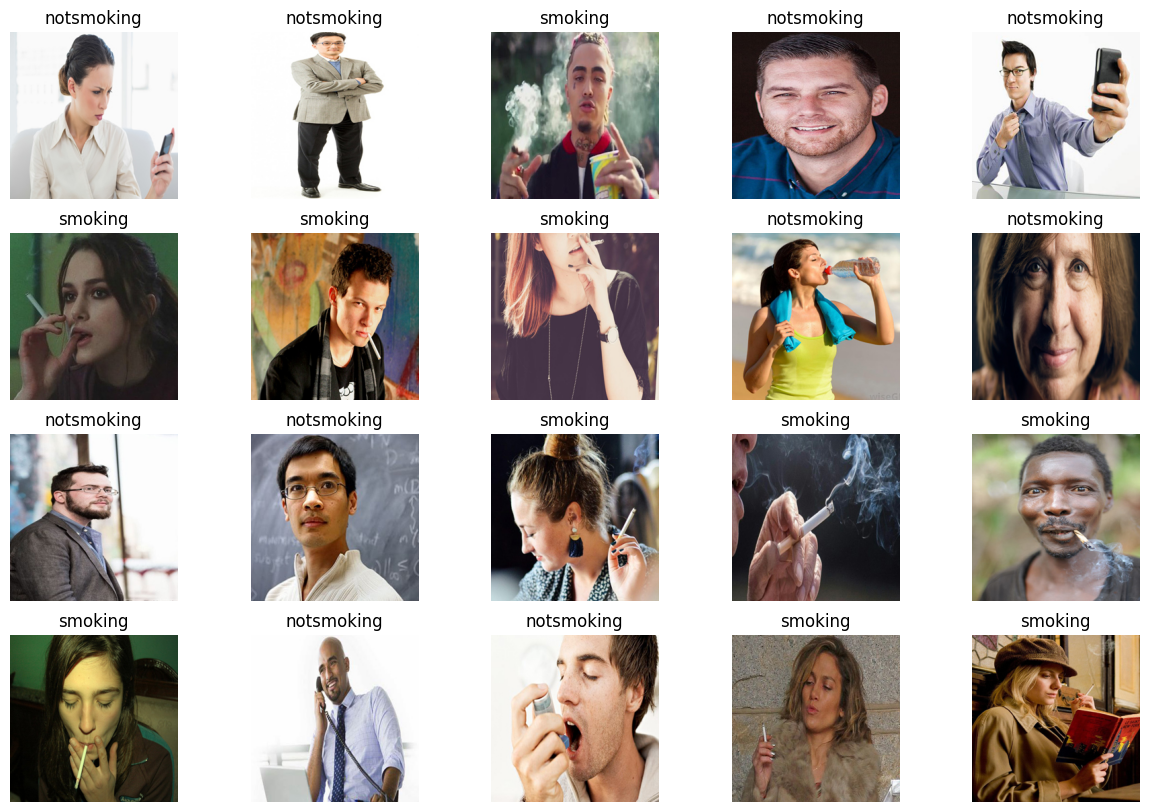

In [12]:
num_img=20
idx=np.random.randint(0,len(train_df), size=num_img)
fig, axes = plt.subplots(num_img//5, 5, figsize=(15,10))
axes=axes.flatten()
for i, ax in enumerate(axes):
    full_path=train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [13]:
train_transforms = v2.Compose([
    v2.Resize(265),
    v2.RandomResizedCrop(size = (224 , 224) , antialias = True),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomVerticalFlip(.5),
    v2.RandomAffine(degrees=(-10,10),translate=(.1,.1), scale=(.9,1.1)),
    v2.RandomErasing(p=.5,scale = (.1,.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean = [.485,.456,.406] , std = [0.229 , 0.224 , 0.225])
])

In [14]:
test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean = [.485,.456,.406] , std = [0.229 , 0.224 , 0.225])
])

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__ (self, dataframe, transforms_):
        self.df=dataframe
        self.transforms_=transforms_
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        img_path=self.df.iloc[index]['path']
        img=Image.open(img_path).convert("RGB")
        transformed_img=self.transforms_(img)
        class_id=self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [16]:
BATCH_SIZE=7

train_dataset=Dataset(train_df, train_transforms)
val_dataset=Dataset(val_df, test_transforms)
train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [17]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")

train_data: 716
val_data:180


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
class_size=len(label_list)
model=models.swin_v2_b(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:01<00:00, 245MB/s]


In [20]:
model.head=nn.Linear(in_features=model.head.in_features,
                    out_features= class_size)
model(torch.rand((16,3,224,224))).shape

torch.Size([16, 2])

In [21]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = 0
    num_batches = len(dataloader)
    
    model.train()
    epoch_loss , epoch_correct = 0 , 0
    
    for i ,(data_ , target_) in enumerate(dataloader):
        target_ = target_.type(torch.LongTensor)
        data_ , target_ = data_.to(device) , target_.to(device)
        
        
        
        outputs = model(data_)
        
        loss = loss_fn(outputs , target_)
        epoch_loss =+ loss.item()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _ , pred = torch.max(outputs , dim = 1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
        size += target_.shape[0]
    lr_scheduler.step()
    return epoch_correct/size , epoch_loss / num_batches

In [22]:
def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad():
        model.eval()
        for i, (data_ , target_) in enumerate(dataloader):
            target_ = target_.type(torch.LongTensor)
            data_ , target_ = data_.to(device) , target_.to(device)  
            
            outputs = model(data_)
            
            loss = loss_fn(outputs , target_)
            
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs , dim = 1)
            epoch_correct += torch.sum(pred == target_).item()
            
            size+= target_.shape[0]
    return epoch_correct/size  , epoch_loss / num_baches

In [23]:
EPOCHS = 87
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
momentum = .9
weight_decay = .1

optmizer = torch.optim.AdamW(model.parameters() , lr = learning_rate)

lr_milestones = [7 , 14, 21 , 28 , 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optmizer ,
                                                   milestones=lr_milestones,
                                                   gamma = .1)

patience = 8
counter = 0
best_loss = np.inf

In [24]:
model.to(device)

for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   model ,
                                   criterion ,
                                   optmizer ,
                                   multi_step_lr_scheduler)
    val_acc , val_loss = test(val_loader , model , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optmizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict() , "checkpoints/best.pth")
    else:
        counter+=1
    if counter >= patience:
        print("Early stop !")
        break

  0%|          | 0/87 [00:00<?, ?it/s]

epoch:0     train_loss = 0.0062 , train_acc:0.5000     val_loss = 0.6885 , val_acc:0.5111     learning rate: 0.0001


  1%|          | 1/87 [00:50<1:11:57, 50.20s/it]

epoch:1     train_loss = 0.0074 , train_acc:0.5684     val_loss = 0.5830 , val_acc:0.7278     learning rate: 0.0001


  2%|▏         | 2/87 [01:33<1:05:18, 46.10s/it]

epoch:2     train_loss = 0.0045 , train_acc:0.5293     val_loss = 0.5798 , val_acc:0.7333     learning rate: 0.0001


  5%|▍         | 4/87 [03:01<1:02:00, 44.83s/it]

epoch:3     train_loss = 0.0050 , train_acc:0.6439     val_loss = 0.6036 , val_acc:0.6778     learning rate: 0.0001
epoch:4     train_loss = 0.0050 , train_acc:0.6676     val_loss = 0.4630 , val_acc:0.7722     learning rate: 0.0001


  7%|▋         | 6/87 [04:30<1:00:03, 44.49s/it]

epoch:5     train_loss = 0.0031 , train_acc:0.7011     val_loss = 0.5730 , val_acc:0.6611     learning rate: 0.0001


  8%|▊         | 7/87 [05:14<58:56, 44.20s/it]  

epoch:6     train_loss = 0.0008 , train_acc:0.7318     val_loss = 0.6698 , val_acc:0.7056     learning rate: 1e-05
epoch:7     train_loss = 0.0100 , train_acc:0.7626     val_loss = 0.3444 , val_acc:0.8667     learning rate: 1e-05


 10%|█         | 9/87 [06:41<56:59, 43.84s/it]

epoch:8     train_loss = 0.0066 , train_acc:0.7835     val_loss = 0.3496 , val_acc:0.8389     learning rate: 1e-05
epoch:9     train_loss = 0.0022 , train_acc:0.8087     val_loss = 0.3086 , val_acc:0.8833     learning rate: 1e-05


 11%|█▏        | 10/87 [07:25<56:20, 43.91s/it]

epoch:10     train_loss = 0.0017 , train_acc:0.8156     val_loss = 0.2787 , val_acc:0.8889     learning rate: 1e-05


 13%|█▎        | 11/87 [08:09<55:40, 43.95s/it]

epoch:11     train_loss = 0.0033 , train_acc:0.8324     val_loss = 0.2673 , val_acc:0.8889     learning rate: 1e-05


 14%|█▍        | 12/87 [08:53<54:57, 43.97s/it]

epoch:12     train_loss = 0.0007 , train_acc:0.8268     val_loss = 0.2404 , val_acc:0.9000     learning rate: 1e-05


 15%|█▍        | 13/87 [09:37<54:21, 44.07s/it]

epoch:13     train_loss = 0.0031 , train_acc:0.8547     val_loss = 0.2238 , val_acc:0.9000     learning rate: 1.0000000000000002e-06


 17%|█▋        | 15/87 [11:05<52:41, 43.91s/it]

epoch:14     train_loss = 0.0007 , train_acc:0.8561     val_loss = 0.2347 , val_acc:0.8944     learning rate: 1.0000000000000002e-06


 18%|█▊        | 16/87 [11:48<51:43, 43.71s/it]

epoch:15     train_loss = 0.0050 , train_acc:0.8631     val_loss = 0.2284 , val_acc:0.8944     learning rate: 1.0000000000000002e-06


 20%|█▉        | 17/87 [12:31<50:50, 43.57s/it]

epoch:16     train_loss = 0.0100 , train_acc:0.8631     val_loss = 0.2309 , val_acc:0.9000     learning rate: 1.0000000000000002e-06


 21%|██        | 18/87 [13:15<49:59, 43.48s/it]

epoch:17     train_loss = 0.0109 , train_acc:0.8701     val_loss = 0.2356 , val_acc:0.8944     learning rate: 1.0000000000000002e-06


 22%|██▏       | 19/87 [13:58<49:12, 43.41s/it]

epoch:18     train_loss = 0.0014 , train_acc:0.8743     val_loss = 0.2296 , val_acc:0.9000     learning rate: 1.0000000000000002e-06


 23%|██▎       | 20/87 [14:41<48:27, 43.40s/it]

epoch:19     train_loss = 0.0009 , train_acc:0.8659     val_loss = 0.2320 , val_acc:0.8944     learning rate: 1.0000000000000002e-06


 24%|██▍       | 21/87 [15:25<47:42, 43.36s/it]

epoch:20     train_loss = 0.0024 , train_acc:0.8729     val_loss = 0.2257 , val_acc:0.8944     learning rate: 1.0000000000000002e-07


 24%|██▍       | 21/87 [16:08<50:43, 46.11s/it]

epoch:21     train_loss = 0.0098 , train_acc:0.8771     val_loss = 0.2259 , val_acc:0.8944     learning rate: 1.0000000000000002e-07
Early stop !


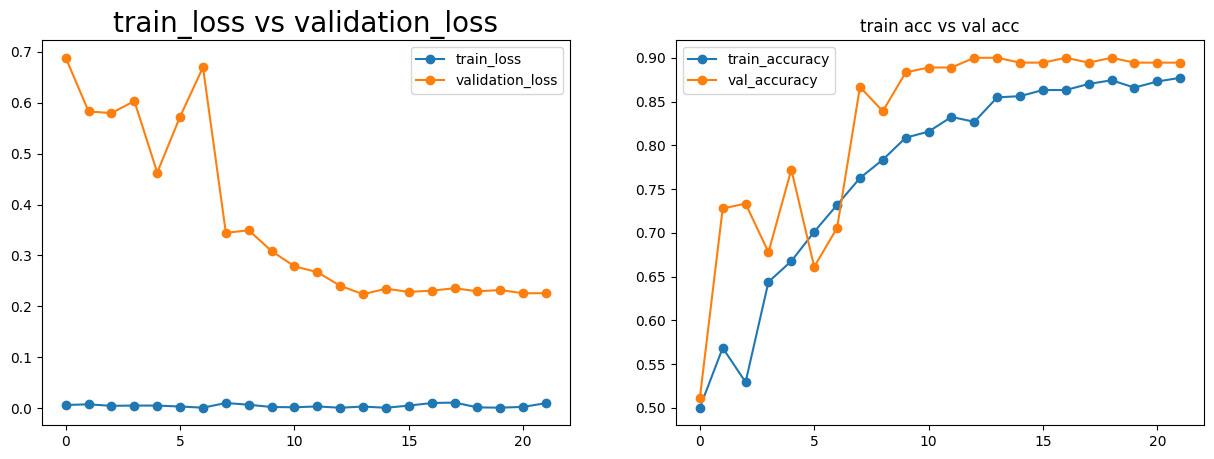

In [25]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='train_loss', marker='o')
plt.plot(logs['val_loss'] , label = 'validation_loss',marker='o')
plt.title('train_loss vs validation_loss' , fontsize = 20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'] , label = 'train_accuracy', marker='o')
plt.plot(logs['val_acc'] , label = 'val_accuracy', marker='o')
plt.title('train acc vs val acc')
plt.legend()

In [26]:
test_df = pd.DataFrame({"path":[] , "label":[] , "class_id":[]})
test_path = '/kaggle/input/smoking/Testing/Testing'
img_list = glob(test_path + "/*.jpg")
for img in img_list:
    file_name = os.path.splitext(img)[0].split("/")[-1]
    if file_name[:len(label_list[0])] == label_list[0]:
        new_data = pd.DataFrame({"path":img , "label":label_list[0] , "class_id": 0} , index = [1])
        test_df = pd.concat([test_df , new_data] , ignore_index = True)
    elif file_name[:len(label_list[1])] == label_list[1]:
        new_data = pd.DataFrame({"path":img , "label":label_list[1] , "class_id":1} , index = [1])
        test_df = pd.concat([test_df , new_data] , ignore_index = True)

In [27]:
test_df[["path"]] = test_df[["path"]].astype(str) 
test_df[["label"]] = test_df[["label"]].astype(str) 
test_df[["class_id"]] = test_df[["class_id"]].astype(int) 

In [28]:
test_dataset = Dataset(test_df , test_transforms)
test_loader = DataLoader(test_dataset , batch_size= BATCH_SIZE)

In [29]:
model.load_state_dict(torch.load("/kaggle/working/checkpoints/best.pth"))
model.eval()

y_true , y_pred = [] , []

with torch.no_grad():
    for (data_ , target_) in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor)
        data_ , target_ = data_.to(device) , target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs , dim = 1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


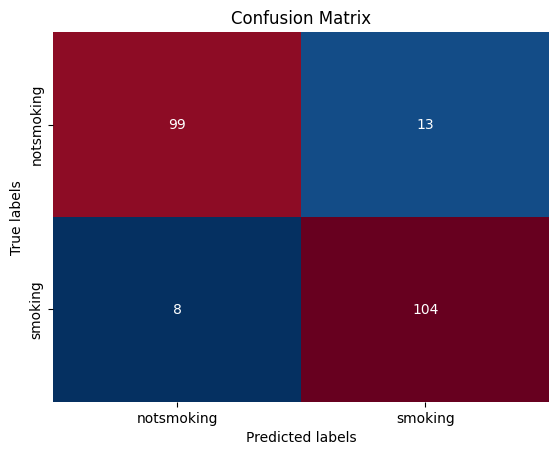

In [30]:
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

In [31]:
clf_report = classification_report(y_true, y_pred, target_names = label_list)

In [32]:
print(clf_report)

              precision    recall  f1-score   support

  notsmoking       0.93      0.88      0.90       112
     smoking       0.89      0.93      0.91       112

    accuracy                           0.91       224
   macro avg       0.91      0.91      0.91       224
weighted avg       0.91      0.91      0.91       224

